In [11]:
from src.scripts.util.common import Dataset, State, load_test
import pandas as pd

PREDICTIONS_DICT = "C:\\Users\\Asia\\Documents\\Projekty\\PyCharm Projects\\text-classification\\results\\predictions\\"
DIAGRAM_DICT = "C:\\Users\\Asia\\Documents\\Projekty\\PyCharm Projects\\text-classification\\results\\diagrams\\"
METRICS_DICT = "C:\\Users\\Asia\\Documents\\Projekty\\PyCharm Projects\\text-classification\\results\\metrics\\"
ROC_AUC_DIR = "C:\\Users\\Asia\\Documents\\Projekty\\PyCharm Projects\\text-classification\\results\\roc_auc_eps\\"

In [2]:
clfs = ["rf","knn", "log", "svc"]
columns = [f"{s.value}-{m}" for m in ["roc", "pr"] for s in [State.BIO,State.STD, State.DOUBLE]]
index = [f"{d.value}-{c}" for c in clfs for d in Dataset]
df_scores_macro =pd.DataFrame(columns=columns, index=index)

In [3]:
from sklearn.metrics import precision_score, roc_auc_score

In [4]:
for d in Dataset:
    for s in [State.BIO,State.STD, State.DOUBLE]:
        for c in ['log', 'rf','knn', 'svc']:
            y_pred = pd.read_csv(PREDICTIONS_DICT + f"predictions-{d.value}-{s.value}-{c}-balanced.csv",index_col=0)["predictions"]
            _, y_true= load_test(d,s)
            y_scores = pd.read_csv(PREDICTIONS_DICT + f"scores-{d.value}-{s.value}-{c}-balanced.csv",index_col=0)

            # Sort index to make sure examples are compared with the right predictions and scores
            y_true = y_true.sort_index()
            y_pred = y_pred.sort_index()
            y_scores = y_scores.sort_index()

            # calculate roc auc scores and average precision
            if d == Dataset.IMDB or d == Dataset.DISASTERS:
                if d == Dataset.IMDB:
                    pos_label ="positive"
                else:
                    pos_label ="Relevant"

                score_binary = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
                df_scores_macro.loc[f"{d.value}-{c}"][f"{s.value}-pr"] = score_binary
                roc_binary_macro = roc_auc_score(y_true, y_scores[pos_label], average='macro')
                df_scores_macro.loc[f"{d.value}-{c}"][f"{s.value}-roc"] = roc_binary_macro

            # multi class classification metrics are handled slightly different
            else:
                score_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
                df_scores_macro.loc[f"{d.value}-{c}"][f"{s.value}-pr"] = score_macro
                roc_macro = roc_auc_score(y_true, y_scores, average='macro', multi_class='ovr')
                df_scores_macro.loc[f"{d.value}-{c}"][f"{s.value}-roc"] = roc_macro

In [5]:
def df_to_latex (df: pd.DataFrame, label:str, caption):
    latex = "\\begin{table}[!h] \label{" +label+ "} \centering\n" \
            "\caption{" + caption + "}" \
            "\\begin{tabular}{"
    cols = df.columns.tolist()
    latex += '| c ' * (len(cols) + 1)
    latex += '|}\hline \n'
    latex += "Zbiór danych & " + " & ".join(cols)  + "\\\\ \cline{3-8} \n"

    for index,row in df.iterrows():
        latex += str(index) + " & "
        for c in cols:
            latex +=  "{0:.2f}".format(row[c]) + " & "
        latex = latex[:-2]  #delete last &
        latex += "\\\\ \cline{2-8}\n"

    latex += "\end{tabular}\n\end{table}\n"
    return latex

In [6]:
df_scores_macro.to_csv(f"{METRICS_DICT}\\scores-macro.csv")

In [6]:
dataset_name = {
    Dataset.BBC:  "BBC",
    Dataset.FINE_FOODS: "Fine Foods",
    Dataset.AG_NEWS: "Ag's News",
    Dataset.IMDB: "IMDB",
    Dataset.DISASTERS: "Disasters"
}
clf_name_to_proper ={
    "log": "regresja logistyczna",
    "svc": "maszyna wektorów nośnych",
    "knn":"k najbliższych sąsiadów",
    "rf": "las losowy"
}
state_name ={
    State.BIO: "BIO",
    State.STD: "Standard",
    State.DOUBLE: "Double"
}

def save_plot_data(fpr, tpr, clf_name, dataset):
    plot_dict = dict()
    for state, fpr_v in fpr.items():
        plot_dict[f'fpr-{state.value}'] = fpr_v.tolist()

    for state, tpr_v in tpr.items():
        plot_dict[f'tpr-{state.value}'] = tpr_v.tolist()

    with open(f'{ROC_AUC_DIR}{clf_name}-{dataset.value}-roc_auc.json', 'w') as fp:
        json.dump(plot_dict, fp)


In [7]:
import matplotlib.pyplot as plt

def draw_roc_auc(fpr, tpr, roc_auc,title):
    #clear any figures
    plt.show()
    plt.figure(figsize=(7.68,5.76))
    #control font sizes for all elements
    MEDIUM_SIZE = 16
    SMALLER_SIZE = 14

    plt.rc('font', size=20)          # controls default text sizes
    plt.rc('axes', titlesize=18)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

    colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#F0E442", "#56B4E9"]
    ax = plt.gca()
    for idx,state in enumerate(fpr.keys()):
         ax.plot(
            fpr[state], tpr[state],
            label="ROC dla {}, AUC = {:0.2f}".format(state_name[state], roc_auc[state]),
             color=colors[idx]
        )
    # reference line
    ax.plot([0, 1], [0, 1], linestyle=":", c=colors[-1])

    ax.set_title(title)
    ax.legend(loc="lower right", frameon=True)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.02])

    ax.set_ylabel("Czułość")
    ax.set_xlabel("1-Swoistość")

In [8]:
import numpy as np

def plot_macro_roc_auc(y_test, y_score, classes):
    fpr = dict()
    tpr = dict()

    for idx, cl in enumerate(classes):
        y_true = y_test.apply(lambda result: 1 if str(result) == cl else 0)
        fpr[idx], tpr[idx],_ = roc_curve(y_true, y_score[cl])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[fine-foods][log]


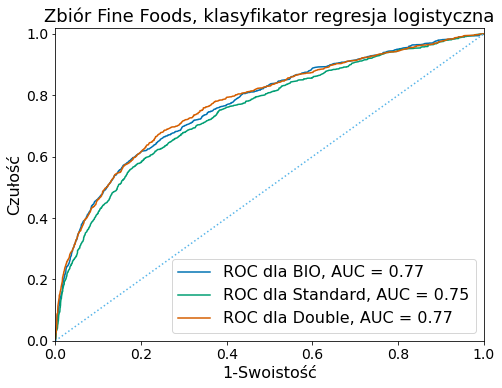

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[fine-foods][knn]


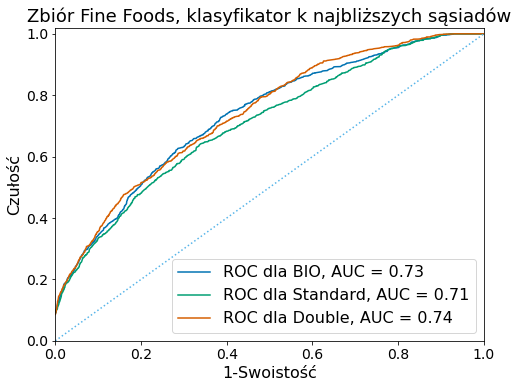

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[fine-foods][rf]


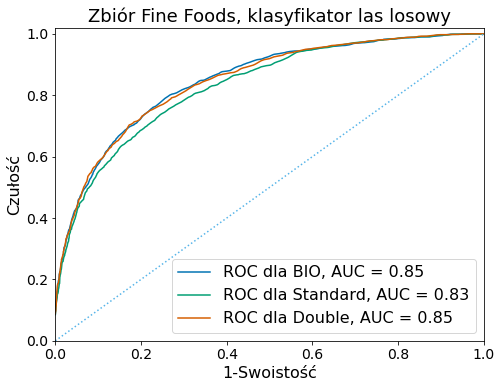

In [15]:
import json
from sklearn.metrics import roc_curve, auc
for d in Dataset:
    for c in [ 'log', 'knn', 'rf', 'svc']:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for s in [State.BIO,State.STD, State.DOUBLE]:
            y_pred = pd.read_csv(PREDICTIONS_DICT + f"predictions-{d.value}-{s.value}-{c}-balanced.csv",index_col=0)["predictions"]
            _, y_true= load_test(d,s)
            y_scores = pd.read_csv(PREDICTIONS_DICT + f"scores-{d.value}-{s.value}-{c}-balanced.csv",index_col=0)

            # Sort index to make sure examples are compared with the right predictions and scores
            y_true = y_true.sort_index()
            y_pred = y_pred.sort_index()
            y_scores = y_scores.sort_index()

            # calculate roc auc for binary
            if d == Dataset.IMDB or d == Dataset.DISASTERS:
                if d == Dataset.IMDB:
                    pos_label ="positive"
                else:
                    pos_label ="Relevant"
                fpr[s], tpr[s], _ = roc_curve(y_true, y_scores[pos_label], pos_label = pos_label)
                roc_auc[s] = auc(fpr[s], tpr[s])
            else:
                fpr[s], tpr[s], roc_auc[s] = plot_macro_roc_auc(y_true, y_scores, y_scores.columns.tolist())

        save_plot_data(fpr, tpr,c, d)
        draw_roc_auc(fpr, tpr, roc_auc, f"Zbiór {dataset_name[d]}, klasyfikator {clf_name_to_proper[c]}")
        plt.savefig(f"{ROC_AUC_DIR}/{d.value}-{c}-macro.eps")
        print(f"[{d.value}][{c}]")

In [ ]:
#RECREATE FINE FOODS SVC - problems with classnames being numbers
from sklearn.metrics import auc
for d in [Dataset.FINE_FOODS]:
    for c in ['svc','log','knn', 'rf']:
        fname = f'./{c}-{d.value}-roc_auc.json'
        with open(fname, 'r') as fp:
            content = json.load(fp)
            
        # change formats
        fpr = dict()
        fpr[State.BIO] = content['fpr-bio']
        fpr[State.STD] = content['fpr-std']
        fpr[State.DOUBLE] = content['fpr-double']
        tpr = dict()
        tpr[State.BIO] = content['tpr-bio']
        tpr[State.STD] = content['tpr-std']
        tpr[State.DOUBLE] = content['tpr-double']
        
        #calculate roc auc based on fpr and tpr
        roc_auc = dict()
        for s in [State.BIO, State.DOUBLE, State.STD]:
            roc_auc[s] = auc(fpr[s], tpr[s])
        
        draw_roc_auc(fpr, tpr, roc_auc, f"Zbiór {dataset_name[d]}, klasyfikator {clf_name_to_proper[c]}")
        plt.savefig(f"{ROC_AUC_DIR}/{d.value}-{c}-macro.eps")
        print(f"[{d.value}][{c}]")